In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve,brentq,least_squares,minimize,basinhopping
from scipy.interpolate import interp1d
from collections import deque
from scipy.stats import norm
import copy

In [3]:
xls=pd.ExcelFile('IR Data.xlsx')
IRS=pd.read_excel(xls,'IRS',header=0)
OIS=pd.read_excel(xls,'OIS',header=0)
swaption=pd.read_excel(xls,'Swaption',header=2)
IRSR=IRS['Rate'].values
Tenor=[0.5,1,2,3,4,5,7,10,15,20,30]
OISR=OIS['Rate'].values

### Part 1 (Bootstrapping Swap Curves)
1. In the **IR Data.xlsm** spreadsheeet, OIS data is provided. Bootstrap the OIS discount factor $D_0(0,T)$ and plot the discount curve for $T \in[0, 30]$.

In [4]:
#A helper function to interpolate inbetween discount factors
def interp(a,b,n):
    p=(b-a)/n
    points=[a+i*p for i in range(1,n)]
    return points

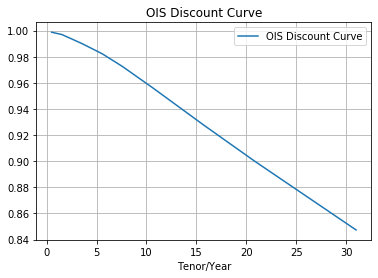

In [5]:
OISdisc=[]
OISdisc.append(1/(1+OISR[1]))

for i in range(2,len(Tenor)): 
    if len(OISdisc)+1<Tenor[i]:
        n=Tenor[i]-len(OISdisc)-1+1
#        the fsolve rootfinding the OIS discount factor that equates the fixed leg with floating leg
        x=fsolve(lambda d:(sum(OISdisc)+d+np.sum(interp(OISdisc[-1],d,n)))*OISR[i]-(1-d),x0=0.9)[0]
    
#        Append the interpolated discountfactors first
        OISdisc.extend(interp(OISdisc[-1],x,n))
        OISdisc.append(x)
        
    else:
        OISdisc.append(fsolve(lambda d:(sum(OISdisc)+d)*OISR[i]-(1-d),x0=0.9)[0])
        
OISdisc1=copy.deepcopy(OISdisc)
OISD1=deque(OISdisc1)
#The discount factors from 6m libor rate is appended left in the last step
OISD1.appendleft(1/(1+0.5*OISR[0]))

t=np.linspace(0.5,31,31)
plt.plot(t,OISD1,label='OIS Discount Curve')
plt.legend()
plt.grid(True)
plt.xlabel('Tenor/Year')
plt.title('OIS Discount Curve')
plt.show()

2. Using the IRS data provided, bootstrap the LIBOR discount factor $D(0, T)$, and plot it for $T\in[0, 30]$.<br>
    $\Rightarrow$ Assume that the swap market is collateralized in cash and overnight interest is paid on collateral posted.

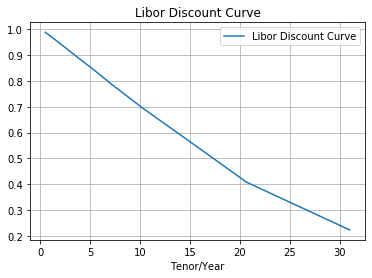

In [6]:
OISDh=[]
OISdisc2=copy.deepcopy(OISdisc)

# Since the IRS is semiannual paied, the half-year OIS discount factor should be intepolated
for i in range(1,len(OISdisc2)):
    d=(OISdisc2[i]+OISdisc2[i-1])/2
    OISDh.append(d)

#Insert the intepolated OIS discount factors into the OIS DF list in order
epsilon=0
for j,d in enumerate(OISDh,1):
    OISdisc2.insert(j+epsilon,d)
    epsilon+=1
OISD2=deque(OISdisc2)
OISD2.appendleft(1/(1+0.5*OISR[0]))
OISDarray=np.array(OISD2) #we will use this later in part2

#A helper function that calculates forward Libor rate from Libor discount factors.
def DF_to_rate(df,x,n,gap,delta=0.5):
    if n<=2:
        df1=np.append(df,x)
        rate=[(df1[i-1]-df1[i])/(df1[i]*delta) for i in range(1,n)]
    else:
        midrate=interp(df[-1],x,gap+1)
        df1=np.append(df,midrate)
        df1=np.append(df1,x)
        rate=[(df1[i-1]-df1[i])/(df1[i]*delta) for i in range(1,n)]
    rate0=[IRSR[0]]
    rate0.extend(rate)
    return rate0

# Compute Libor Discount Factors
LiborDF=[]
LiborDF.append(1/(1+0.5*IRSR[0]))

for i in range(1,len(Tenor)):
    j=Tenor[i]
    gap=j*2-len(LiborDF)-1
#    fsovle rootfinding the libor discount factor that equates fixed payments with floating payments
#    payments are discounted with OIS discount factors
    df=fsolve(lambda d:sum(OISDarray[:j*2])*IRSR[i]-\
              sum(OISDarray[:j*2]*(DF_to_rate(LiborDF,d,j*2,gap))),x0=0.9)[0]
    if i>=2:
        LiborDF.extend(interp(LiborDF[-1],df,gap+1))
        LiborDF.append(df)
    else:
        LiborDF.append(df)
        
t2=np.linspace(0.5,31,60)
plt.plot(t2,LiborDF,label='Libor Discount Curve')
plt.legend()
plt.grid(True)
plt.title('Libor Discount Curve')
plt.xlabel('Tenor/Year')
plt.show()

3. Calculate the following forward swap rates:
    * $1y × 1y, 1y × 2y, 1y × 3y, 1y × 5y, 1y × 10y$ 
    * $5y × 1y, 5y × 2y, 5y × 3y, 5y × 5y, 5y × 10y$ 
    * $10y × 1y, 10y × 2y, 10y × 3y, 10y × 5y, 10y × 10y$

In [7]:
#There are 60 nodes for semiannual payments IRS up to 30 years
Tenor2=[0.5+i*0.5 for i in range(60)]
start=[1,5,10]
end=[1,2,3,5,10]

#Swap rates calculation
def swp_rate(expire,tenor,LiborDF,OISDarray,date):
    assert isinstance(expire,list)
    assert isinstance(tenor,list)
    Swaprates=[]
    for i in expire:
        for j in tenor:
#        Specify individual node of payment for each forward swap
            node=[i+n*0.5 for n in range(0,j*2+1)]
#        For every node there is a index which corresponds to a particular discount factor
            m=[date.index(t) for t in node]
            fwdrate=np.array([(LiborDF[n]-LiborDF[n+1])/(0.5*LiborDF[n+1]) for n in m[:-1]]) 
            fwddf=np.array([OISDarray[n] for n in m[1:]]) 
#        The forward swap rate that equates fixed payments with floating payments
            swprate=fwddf@fwdrate/np.sum(fwddf)
            Swaprates.append((str(i)+'y'+'*'+str(j)+'y',swprate))
    return Swaprates

Swaprates=swp_rate(start,end,LiborDF,OISDarray,Tenor2)
#Dictonary comprehension, then export into DataFrame
SwprateDict={y:rate for y,rate in Swaprates }
Swpdf=pd.DataFrame.from_dict(SwprateDict, orient='index',columns=['Fwd Swap rates'])
print(Swpdf)

         Fwd Swap rates
1y*1y          0.032007
1y*2y          0.033259
1y*3y          0.034011
1y*5y          0.035255
1y*10y         0.038428
5y*1y          0.039274
5y*2y          0.040075
5y*3y          0.040072
5y*5y          0.041093
5y*10y         0.043634
10y*1y         0.042189
10y*2y         0.043116
10y*3y         0.044097
10y*5y         0.046249
10y*10y        0.053458


### Part 2 (Swaption Calibration)
   Under the Swaption tab of IR Data.xlsm, swaption implied volatilities (lognormal) are provided.
   1. Calibrate the displaced-diﬀusion model to the swaption market data, and document
        - a table of $\sigma$ parameters
        - a table of $\beta$ parameters
        
   2. Calibrate the SABR model to the swaption market data using $\beta = 0.9$, and document
        - a table of $\alpha$ parameters
        - a table of $\rho$ parameters
        - a table of $\nu$ parameters

In [8]:
xls=pd.ExcelFile('IR Data.xlsx')
swaption=pd.read_excel(xls,'Swaption',header=2)
swaption

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297
1,1Y,2Y,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
2,1Y,3Y,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833
3,1Y,5Y,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
4,1Y,10Y,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
5,5Y,1Y,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980
6,5Y,2Y,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760
7,5Y,3Y,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150
8,5Y,5Y,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400
9,5Y,10Y,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250


In [9]:
def Black76Lognormal(F, K, sigma, T, df, por):
    d1 = (np.log(F/K)+(0.5*(sigma**2)*T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if por == 0: #payer
        return df*(F*norm.cdf(d1) - K*norm.cdf(d2))
    if por == 1: #receiver
        return df*(K*norm.cdf(-d2) - F*norm.cdf(-d1))


def Displaced_Diffusion(F, K, sigma, beta, T, df, por):
    Fd = F/beta
    Kd = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    return Black76Lognormal(Fd, Kd, sigma_d, T, df, por)

    
def impliedVolatility(price, F, K, T, df, por, x0):
    impliedVol = fsolve(lambda x: price - Black76Lognormal(F, K, x, T, df, por), x0)
    #impliedVol = minimize(lambda x: price - Black76Lognormal(F, K, x, T, df, por), 0.1)
    return impliedVol

In [10]:
# SABR Model

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [11]:
#A function calculates all the PVBP in one go and present in order in line
# with the swaption DataFrame index
def PVBP(expire,tenor,dfidx,DF,dt):
    assert isinstance(expire,list)
    assert isinstance(tenor,list)
    PVBP=[]
    for i in expire:
        for j in tenor:
            date=[i+dt*n for n in range(1,j*2+1)]
            df=[DF[dfidx.index(i)] for i in date]
            PVBP.append(dt*sum(df)) 
    return PVBP


In [12]:
#do not delete!

def SABRcalib(vols, F, strike, T, df, x):
    err = 0.0
    for i, vol in enumerate(vols):
        k = F + strike[i]
        err += (vol - SABR(F, k, T, x[0], 0.9, x[1], x[2]))**2
    return err  

def DDcalib(vols, F, strike, T, df, sigma, x):
    err = 0.0
    for i,vol in enumerate(vols):
        if strike[i] >= 0:
            por = 0
        if strike[i] < 0:
            por = 1
        err += (vol - impliedVolatility(Displaced_Diffusion(F, F+strike[i], sigma, x, T, df, por), F, F+strike[i], T, df, por, vol))**2
    return err

In [13]:
ATMidx = swaption.columns.get_loc('ATM')-2
strike = np.array([-200,-150,-100,-50,-25,0,25,50,100,150,200])/10000
dfidx = [0.5 + i*0.5 for i in range(60)]
expire = [1, 5, 10]
tenor = [1, 2, 3, 5, 10]
dt = 0.5
N = len(expire)*len(tenor)
pvbp = PVBP(expire, tenor, dfidx, OISDarray, dt)

In [15]:
# Do not delete this!!!!
Alpha, Rho, Nu, Sigma, Beta = [], [], [], [], []

for n in range(len(expire)*len(tenor)):
    # SABR calibration
    ressabr = least_squares(lambda x: SABRcalib(swaption.iloc[n,2:]/100, Swpdf.iloc[n,0], strike, expire[n//5], pvbp[n], x), [0.2, -0.5, 0.6])
    Alpha.append(ressabr.x[0])
    Rho.append(ressabr.x[1])
    Nu.append(ressabr.x[2])

    swp = swaption.iloc[n,2:]/100
    swpv = swp.values
    swp_ATM = swp[ATMidx]
    sigma_match = brentq(lambda x: swp_ATM - impliedVolatility(Displaced_Diffusion(Swpdf.iloc[n,0], Swpdf.iloc[n,0], x, 0.5, expire[n//5], pvbp[n], 1),Swpdf.iloc[n,0], Swpdf.iloc[n,0], expire[n//5], pvbp[n], 1, swp_ATM)[0], 1e-6, 1)
    bnds = [(None, 0)]
    if n == 0:
        beta_match = minimize(lambda x: DDcalib(swpv, Swpdf.iloc[n,0], strike, expire[n//5], pvbp[n], sigma_match, x), -1, method='SLSQP', bounds=bnds)
    else:
        beta_match = minimize(lambda x: DDcalib(swpv, Swpdf.iloc[n,0], strike, expire[n//5], pvbp[n], sigma_match, x), 0.1)
    Sigma.append(sigma_match)
    #Beta.append(beta_match)
    Beta.append(beta_match.x[0])
    

In [16]:
# A helper function to present parameters in the required format
def Tabulate(data):
    assert isinstance(data,list)
    columns=[str(i)+'Y' for i in tenor]   
    datadict={str(expire[i])+'Y':data[i*5:5+i*5] for i in range(len(expire))}
    datadf=pd.DataFrame.from_dict(datadict,orient='index',columns=columns)
    return datadf

In [17]:
Alphadf=Tabulate(Alpha)
Rhodf=Tabulate(Rho)
Nudf=Tabulate(Nu)

Sigmadf=Tabulate(Sigma)
Betadf=Tabulate(Beta)

print('For SABR Calibration\nAlphadf is:\n', Alphadf,'\nRhodf is:\n', Rhodf,'\nNudf is:\n', Nudf)
print('\nFor DD Calibration\nSigmadf is:\n', Sigmadf,'\nBetadf is:\n', Betadf)

For SABR Calibration
Alphadf is:
            1Y        2Y        3Y        5Y       10Y
1Y   0.146185  0.189236  0.202707  0.184948  0.177746
5Y   0.163946  0.198974  0.210863  0.192125  0.176388
10Y  0.173583  0.191117  0.201891  0.195694  0.177760 
Rhodf is:
            1Y        2Y        3Y        5Y       10Y
1Y  -0.609327 -0.524888 -0.494351 -0.449873 -0.345790
5Y  -0.565809 -0.540923 -0.548872 -0.516649 -0.439310
10Y -0.529817 -0.530199 -0.534894 -0.543872 -0.499459 
Nudf is:
            1Y        2Y        3Y        5Y       10Y
1Y   1.937656  1.629383  1.384715  0.999400  0.685586
5Y   1.306989  1.052791  0.929525  0.665801  0.507689
10Y  0.988598  0.910910  0.854329  0.713149  0.589367

For DD Calibration
Sigmadf is:
            1Y        2Y        3Y        5Y       10Y
1Y   0.224644  0.286461  0.296976  0.260147  0.244243
5Y   0.269453  0.294182  0.295620  0.263076  0.242810
10Y  0.278230  0.285063  0.286169  0.261493  0.239220 
Betadf is:
            1Y        2Y        3Y

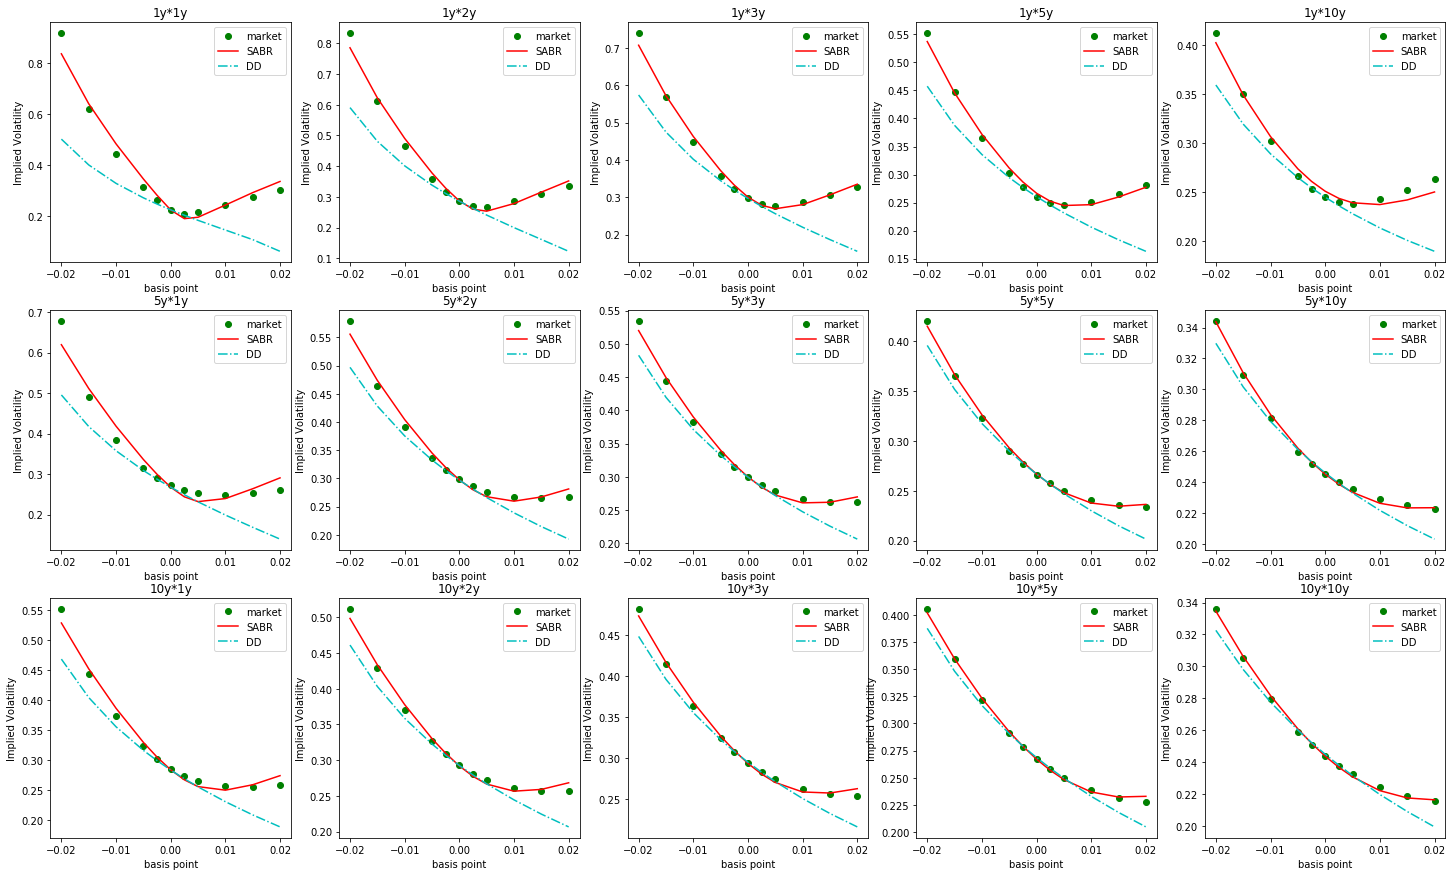

In [20]:
fig = plt.figure(figsize=(25,15))
for e in range(3):
    #fig = plt.figure(figsize=(13,7))
    #fig.add_subplot(111)
    for t in range(5):
        impvoldd = []
        n = 5*e+t
        fig.add_subplot(3,5,n+1)
        F = Swpdf.iloc[n,0]
        vol = swaption.iloc[n,2:]/100
        for i in range(len(strike)):
            k = F + strike[i]
            if strike[i] >= 0:
                por = 0
            else:
                por = 1
            impvoldd.append(impliedVolatility(Displaced_Diffusion(F, k, Sigma[n], Beta[n], expire[n//5], pvbp[n], por), F, k, expire[n//5], pvbp[n], por, vol[i]))
        sabr=[SABR(F, F+k, expire[n//5], Alpha[n], 0.9, Rho[n], Nu[n]) for k in strike]
        plt.plot(strike, vol.values, 'go', label = 'market')
        plt.plot(strike, sabr, 'r-',label='SABR')
        plt.plot(strike, impvoldd, 'c-.', label='DD')
        plt.xlabel('basis point')
        plt.ylabel('Implied Volatility')
        plt.title(label=Swpdf.index[n])
        plt.legend()
plt.savefig('all.pdf')
plt.show()

In [158]:
#A helper function to draw implied volatility smile.
'''
def impliedVol(F, strike, Vol, T, df, sigma, beta, alpha, rho, nu):
    impvoldd = []
    for i in range(len(strike)):
        k = F + strike[i]
        if strike[i] >= 0:
            por = 0
        else:
            por = 1
        impvoldd.append(impliedVolatility(Displaced_Diffusion(F, k, sigma, beta, T, df, por), F, k, T, df, por, Vol[i]))
        
    sabr=[SABR(F, F+k, T, alpha, 0.9, rho, nu) for k in strike]
    print(impvoldd)
    plt.plot(strike, Vol.values, 'go', label='Mkt')
    plt.plot(strike, impvoldd, 'b', label='DD')
    plt.plot(strike, sabr,'k',label='SABR')
    plt.xlabel('basis point')
    plt.ylabel('Implied Volatility')
    plt.title(Swpdf.index[n])
    plt.legend()
    plt.savefig(Swpdf.index[n]+'.pdf')
    plt.show()
'''

In [182]:
#for n in range(len(expire)*len(tenor)):
 #   impliedVol(Swpdf.iloc[n,0], strike, swaption.iloc[n,2:]/100, expire[n//5], pvbp[n], Sigma[n], Beta[n], Alpha[n], Rho[n], Nu[n])

In [183]:
#Q3
K=[i/100 for i in range(1,9)]
expire = [1, 5, 10]
#A helper function to interpolate parameters for the specified expire/tenor
def param_interp(df, tenor, date, expire):
    assert isinstance(df,pd.DataFrame)
    if date<expire[0]:
            new_p1=df[str(tenor)+'Y'][str(expire[0])+'Y']-\
            (expire[0]-date)/expire[0]*df[str(tenor)+'Y'][str(expire[0])+'Y']
            return new_p1
    else:
        for i in range(len(expire)):
            if expire[i]<date<expire[i+1]:
                new_p2=df[str(tenor)+'Y'][str(expire[i])+'Y']+(date-expire[i])/(expire[i+1]-expire[i])*\
            (df[str(tenor)+'Y'][str(expire[i+1])+'Y']- df[str(tenor)+'Y'][str(expire[i])+'Y'])
                return new_p2

# payer 2Y*10Y and receiver 8Y*10Y require new parameters
p_sigma=param_interp(Sigmadf,10,2,expire)
p_beta=param_interp(Betadf,10,2,expire)
p_alpha=param_interp(Alphadf,10,2,expire)
p_rho=param_interp(Rhodf,10,2,expire)
p_nu=param_interp(Nudf,10,2,expire)

r_sigma=param_interp(Sigmadf,10,8,expire)
r_beta=param_interp(Betadf,10,8,expire)
r_alpha=param_interp(Alphadf,10,8,expire)
r_rho=param_interp(Rhodf,10,8,expire)
r_nu=param_interp(Nudf,10,8,expire)



pvbp = PVBP([2,8],[10],dfidx,OISDarray,0.5)
S0 = swp_rate([2,8],[10],LiborDF,OISDarray,dfidx)
K=[i/100 for i in range(1,9)]


#Calculate the prices using Displaced Diffusion and SABR model.
DDpayer=[Displaced_Diffusion(S0[0][1], k, p_sigma, p_beta, 2, pvbp[0], 0) for k in K]
SABRpayer=[Black76Lognormal(S0[0][1], k, SABR(S0[0][1], k, 2, p_alpha, 0.9, p_rho, p_nu), 2, pvbp[0], 0) for k in K]


DDreceiver=[Displaced_Diffusion(S0[1][1], k, p_sigma, p_beta, 8, pvbp[1], 1) for k in K]
SABRreceiver=[Black76Lognormal(S0[1][1], k, SABR(S0[1][1], k, 8, p_alpha, 0.9, p_rho, p_nu), 8, pvbp[1], 1) for k in K]

    

model_column=[str(i)+'%' for i in range(1,9)]
model_swaption={'Displaced_Diffusion payer 2Y*10Y':DDpayer,\
                'Displaced_Diffusion receiver 8Y*10Y':DDreceiver,\
                'SABR payer 2Y*10Y':SABRpayer,'SABR receiver 8Y*10Y':SABRreceiver} 
#Incorporate all the prices generated by models into a DataFrame
model_swaption_df=pd.DataFrame.from_dict(model_swaption,orient='index',columns=model_column)  
model_swaption_df

,1%,2%,3%,4%,5%,6%,7%,8%
Displaced_Diffusion payer 2Y*10Y,0.288345,0.195388,0.112723,0.051117,0.016642,0.003552,0.000457,0.000033
Displaced_Diffusion receiver 8Y*10Y,0.021985,0.036837,0.058935,0.090072,0.131636,0.184279,0.247707,0.320704
SABR payer 2Y*10Y,0.289206,0.197774,0.115164,0.052599,0.020580,0.009174,0.005005,0.003164
SABR receiver 8Y*10Y,0.027601,0.049525,0.072550,0.100756,0.140950,0.200174,0.275942,0.360493


In [184]:
writer = pd.ExcelWriter('all.xlsx', engine='xlsxwriter')
Alphadf.to_excel(writer, sheet_name = 'Alpha')
Rhodf.to_excel(writer, sheet_name = 'Rho')
Nudf.to_excel(writer, sheet_name = 'Nu')
Sigmadf.to_excel(writer, sheet_name = 'Sigma')
Betadf.to_excel(writer, sheet_name = 'Beta')
model_swaption_df.to_excel(writer, sheet_name = 'swaption')
writer.save()